In [6]:
from ast import boolop
import torch
import torch.nn as nn

from sklearn.neural_network import MLPClassifier
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
import os
import sys
import argparse
import pickle
import numpy as np
import pandas as pd

import configparser
import argparse
import textwrap

from model_utils import *
from data_utils import _make_dataset
from gaussian import Gaussian

import dice
import gradual_construction
from bayes_cf import *
import face_knn

In [7]:
lipton = pd.read_csv("../data/datasets/lipton/lipton_data.data")

In [3]:
protect_idx = lipton[lipton['gender'] == 0].index

In [4]:
config = configparser.ConfigParser()
config.read('lipton.config')
basic_config = config['Basic']
classifier_config = config['Classifier']
data_config = config['Data']
vae_config = config['Vae']
dice_config = config['DiCE']
bayes_config = config['Bayes']
grad_con_config = config['GradualConstruction']
face_config = config['FACE']

In [5]:
data = _make_dataset(
            fname=basic_config['dataset_path'],
            dag_fname = basic_config['dag_path'],
            softmax_temp = float( data_config['softmax_temp'] ),
            target_column=data_config['target_column'],
            drop_columns=eval( data_config['drop_columns'] ),
            set_na = eval( data_config['set_na'] ),
            immutable_columns = eval( data_config['immutable_columns'] ),
            nonactionable_columns = eval( data_config[ 'nonactionable_columns' ] ),
            log_transform = eval( data_config[ 'log_transform' ] ),
            dataset=basic_config['dataset'],
    )
X = data[:][0] #Get preprocessed data
y = data[:][1] #Get preprocessed labels
X_women = X[data.protect_list]
y_women = y[data.protect_list]
X_men = X[~data.protect_list]
y_men = y[~data.protect_list]

hair_len []
work_exp []


In [13]:
use_X = pd.DataFrame(X.numpy())
def generator_small(data_dim):
    model = Sequential()
    
    model.add(Dense(128, input_dim=data_dim))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(data_dim))
    
    return model

In [14]:
with open("german_dwa.pk", 'rb') as f:
    dwa_args = pickle.load(f)
G = generator_small(X.shape[1])
G.load_weights('lipton_midway')

In [7]:
def pred(X):
    return torch.tensor(G.predict(X))

In [8]:
if classifier_config["classifier"] == "Logistic_Regression":
    classifier = LogisticRegression()
    if y.shape[1] > 1:
        # If one-hot encoding labels, pass labels as the argmax
        classifier.create_model( X.detach(), torch.argmax( y, axis=1 ) )
    else:
        classifier.create_model( X.detach(), y.ravel() ) 

In [9]:
assert lipton.shape[0] == X.shape[0]

In [10]:
lipton['pred'] = np.argmax(classifier(X).detach().numpy(), axis=1)

In [15]:
lipton['paired_pred'] = np.argmax(classifier(pred(X.numpy())).detach().numpy(), axis=1)

In [16]:
protec = lipton[lipton['gender'] == 0]

In [17]:
bad_real = protec[protec['pred'] == 0]

In [18]:
bad_both = bad_real[bad_real['paired_pred'] == 0]

In [21]:
import pickle as pk
with open("lipton_idx.pk", "wb") as f:
    pk.dump(list(bad_both.index), f)

In [4]:
lipton

,Unnamed: 0,work_exp,hair_len,gender,pred
0,0,0.711543,0.003527,0.0,True
1,1,-0.792709,0.876868,0.0,False
2,2,-0.938387,0.551960,0.0,False
3,3,-1.125058,-0.376501,0.0,False
4,4,-0.830734,0.423972,0.0,False
...,...,...,...,...,...
1995,1995,0.204868,-0.905727,1.0,False
1996,1996,1.003855,-1.108976,1.0,False
1997,1997,1.319243,-0.970712,1.0,False
1998,1998,0.976998,-0.927839,1.0,False


In [8]:
with open("lipton_Bayes_work_exp_disps.pk", 'rb') as f:
    bayes_we = np.array(pickle.load(f))
with open("lipton_face_work_exp_disps.pk", 'rb') as f:
    face_we = np.array(pickle.load(f))
with open("lipton_DiCE_work_exp_disps.pk", 'rb') as f:
    DiCE_we = np.array(pickle.load(f))

with open("lipton_Bayes_hair_len_disps.pk", 'rb') as f:
    bayes_hl = np.array(pickle.load(f))
with open("lipton_face_hair_len_disps.pk", 'rb') as f:
    face_hl = np.array(pickle.load(f))
with open("lipton_DiCE_hair_len_disps.pk", 'rb') as f:
    DiCE_hl = np.array(pickle.load(f))

In [9]:
import matplotlib.pyplot as plt

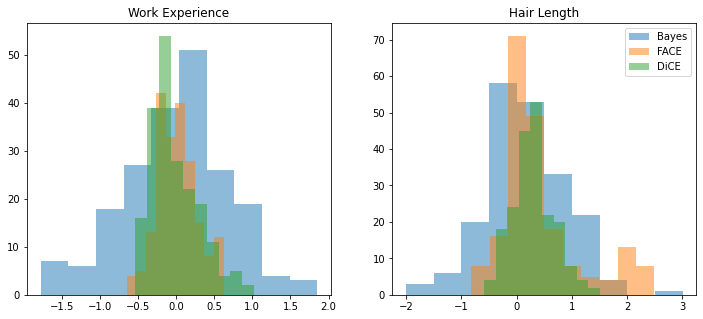

In [10]:
fig, ax = plt.subplots(ncols=2, constrained_layout=False, figsize=(12,5))
ax[0].hist(bayes_we, label = 'Bayes', alpha=0.5)
ax[0].hist(face_we, label = 'FACE',alpha=0.5)
ax[0].hist(DiCE_we, label = 'DiCE',alpha=0.5)
ax[0].set_title("Work Experience")
ax[1].hist(bayes_hl, label = 'Bayes',alpha=0.5)
ax[1].hist(face_hl, label = 'FACE',alpha=0.5)
ax[1].hist(DiCE_hl, label = 'DiCE',alpha=0.5)
ax[1].set_title("Hair Length")
plt.legend()
plt.savefig("lipton_graphs.pdf")